<a href="https://colab.research.google.com/github/shell004/bigquery/blob/main/gnomAD_in_BigQuery.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sample Notebook for exploring gnomAD in BigQuery
This notebook contains sample queries to explore the gnomAD dataset which is hosted through the Google Cloud Public Datasets Program.

## Setup and Authentication

If you just want to look at sample results, you can scroll down to see the output of the existing queries without having to run anything. If you would like to re-run the queries or make changes, you will need to authenticate as your user and set the Google Cloud project in which to run the analysis.

In [1]:
# Import libraries
import numpy as np
import os

# Imports for using and authenticating BigQuery
from google.colab import auth

### User Authentication
Before running any queries using BigQuery, you need to first authenticate yourself by running the following cell. If you are running it for the first time, it will ask you to follow a link to log in using your Google identity account, and accept the data access requests to your profile. Once this is done, it will generate a string of verification code, which you should paste back to the cell below and press enter. This should be a Google account which you can login to and which has access to run BigQuery jobs in the Google Cloud project specified in the next step.

In [2]:
auth.authenticate_user()

### Set Google Cloud Project
To run queries in BigQuery, you need to specify the Google Cloud project that will be used. The queries below report the number of bytes billed by each query. The first 1 TB of query data processed in a project per month is free. For more details, see the [BigQuery Pricing](https://cloud.google.com/bigquery/pricing) page.

To find your Project ID, go to the [Project Settings page](https://console.cloud.google.com/iam-admin/settings) in the Google [Cloud Console](https://console.cloud.google.com/). You can select the project you want using the drop-down menu at the top of the page.

In [3]:
# Replace project_id with your Google Cloud Project ID.
os.environ["GOOGLE_CLOUD_PROJECT"]='meta-buckeye-465304-p9'

Connect to google drive

In [4]:
from google.colab import drive
import pandas as pd

# Mount Google Drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


Load excel file

In [6]:
# Load the Excel file
hotspots_df = pd.read_excel('/content/gdrive/MyDrive/hotspots_v3.xlsx', sheet_name="Sheet1")

In [8]:


# Drop duplicates if needed
hotspots_df = hotspots_df.drop_duplicates(subset=['Hugo_Symbol', 'POS1'])
hotspots_df = hotspots_df.dropna(subset=['POS1', 'Chrom'])
print(hotspots_df['Hugo_Symbol'].unique())

['NRAS' 'PIK3CA' 'IDH1' 'BRAF' 'EGFR' 'TP53' 'KRAS' 'AKT1' 'GNAS' 'FGFR3'
 'PTEN']


Parsing genomic position

In [ ]:
# Clean data
hotspots_df = hotspots_df.drop_duplicates(subset=['Hugo_Symbol', 'Genomic_Position'])
print("\nUnique genes:")
print(hotspots_df['Hugo_Symbol'].unique())

def parse_genomic_positions(position_str):
    """Parse complex genomic position strings into individual positions"""
    positions = []
    for part in position_str.split('|'):
        try:
            chrom_pos, count = part.split('_')
            chrom, pos = chrom_pos.split(':')
            positions.append({
                'chrom': chrom,
                'pos': int(pos),
                'count': int(count)  # Added missing parenthesis and brace
            })
        except ValueError:
            continue
    return positions

# Test parsing
sample_row = hotspots_df.iloc[0]
print("\nParsed genomic positions for first row:")
print(parse_genomic_positions(sample_row['Genomic_Position']))


Unique genes:
['NRAS' 'PIK3CA' 'IDH1']

Parsed genomic positions for first row:
[{'chrom': '1', 'pos': 115256529, 'count': 252}, {'chrom': '1', 'pos': 115256530, 'count': 143}, {'chrom': '1', 'pos': 115256528, 'count': 27}]


Connect to gnomAD server

In [9]:
from google.cloud import bigquery

client = bigquery.Client()

def run_query(query):
    query_job = client.query(query)
    result = query_job.to_dataframe(progress_bar_type='tqdm_notebook')
    gb_processed = (query_job.total_bytes_billed / 1024 ** 3)
    print('This query processed {} GB of data which is {}% of your 1 TB monthly free quota.'.format(gb_processed, round(gb_processed / 1024 * 100, 4)))
    return result

In [23]:

all_results = []

for idx, row in hotspots_df.iterrows():
    try:
        # Skip if POS1 is missing
        if pd.isna(row['POS1']):
            continue

        chrom = str(row['Chrom']).replace("chr", "")  # normalize
        pos = int(row['POS1'])

        # Driver row (no REF/ALT anymore)
        driver_row = pd.DataFrame([{
            'CHROM': f"chr{chrom}",
            'POS': pos,
            'AN': 0,
            'AC': 0,
            'AF': 0.0,
            'Gene': row['Hugo_Symbol'],
            'Hotspot_Center': pos,
            'Distance': 0,
            'Mutation_Count': int(row['Mutation_Count']),
            'Variant_Type': 'Driver'
        }])
        all_results.append(driver_row)




        # ±3 bp SNP search
        start = pos - 3
        end = pos + 3

        query = f"""
        SELECT
            reference_name AS CHROM,
            start_position AS POS,
            AN,
            alternate_bases.AC AS AC,
            alternate_bases.AF AS AF
        FROM `bigquery-public-data.gnomAD.v2_1_1_exomes__chr{chrom}`,
            UNNEST(alternate_bases) AS alternate_bases
        WHERE start_position BETWEEN {start} AND {end}
        ORDER BY POS
        """

        snps = run_query(query)

        if not snps.empty:
            snps['Gene'] = row['Hugo_Symbol']
            snps['Hotspot_Center'] = pos
            snps['Distance'] = snps['POS'] - pos
            snps['Mutation_Count'] = int(row['Mutation_Count'])
            snps['Variant_Type'] = 'SNP'
            all_results.append(snps)

    except Exception as e:
        print(f"Error processing {row['Hugo_Symbol']} at {row['Chrom']}:{row['POS1']} → {str(e)}")
        continue












Query is running:   0%|          |

Downloading:   0%|          |

This query processed 0.0 GB of data which is 0.0% of your 1 TB monthly free quota.


Query is running:   0%|          |

Downloading:   0%|          |

This query processed 0.0 GB of data which is 0.0% of your 1 TB monthly free quota.


Query is running:   0%|          |

Downloading:   0%|          |

This query processed 0.0 GB of data which is 0.0% of your 1 TB monthly free quota.


Query is running:   0%|          |

Downloading:   0%|          |

This query processed 0.0 GB of data which is 0.0% of your 1 TB monthly free quota.


Query is running:   0%|          |

Downloading:   0%|          |

This query processed 0.0 GB of data which is 0.0% of your 1 TB monthly free quota.


Query is running:   0%|          |

Downloading:   0%|          |

This query processed 0.0 GB of data which is 0.0% of your 1 TB monthly free quota.


Query is running:   0%|          |

Downloading:   0%|          |

This query processed 0.0 GB of data which is 0.0% of your 1 TB monthly free quota.


Query is running:   0%|          |

Downloading:   0%|          |

This query processed 0.0 GB of data which is 0.0% of your 1 TB monthly free quota.


Query is running:   0%|          |

Downloading:   0%|          |

This query processed 0.0 GB of data which is 0.0% of your 1 TB monthly free quota.


Query is running:   0%|          |

Downloading:   0%|          |

This query processed 0.0 GB of data which is 0.0% of your 1 TB monthly free quota.


Query is running:   0%|          |

Downloading:   0%|          |

This query processed 0.0 GB of data which is 0.0% of your 1 TB monthly free quota.


Query is running:   0%|          |

Downloading:   0%|          |

This query processed 0.0 GB of data which is 0.0% of your 1 TB monthly free quota.


Query is running:   0%|          |

Downloading:   0%|          |

This query processed 0.0 GB of data which is 0.0% of your 1 TB monthly free quota.


Query is running:   0%|          |

Downloading:   0%|          |

This query processed 0.0 GB of data which is 0.0% of your 1 TB monthly free quota.


Query is running:   0%|          |

Downloading:   0%|          |

This query processed 0.0 GB of data which is 0.0% of your 1 TB monthly free quota.


Query is running:   0%|          |

Downloading:   0%|          |

This query processed 0.0 GB of data which is 0.0% of your 1 TB monthly free quota.


Query is running:   0%|          |

Downloading: |          |

This query processed 0.0 GB of data which is 0.0% of your 1 TB monthly free quota.


Query is running:   0%|          |

Downloading:   0%|          |

This query processed 0.0 GB of data which is 0.0% of your 1 TB monthly free quota.
Error processing PIK3CA at breast:2561:361|bowel:1782:54|uterus:618:51|esophagusstomach:1407:28|cnsbrain:2270:27|headandneck:988:25|bladder:958:20|lung:2761:17|softtissue:739:11|ovaryfallopiantube:699:9|pancreas:1059:7|prostate:1379:6|skin:974:5|unk:357:5|thyroid:618:5|kidney:1304:5|cervix:239:4|biliarytract:358:3|liver:636:3|adrenalgland:291:1:3:178952085_622|3:178952084_18|3:178952086_7 → invalid literal for int() with base 10: '3:178952085_622|3:178952084_18|3:178952086_7'


In [13]:


hotspots_df = hotspots_df.dropna(subset=['Genomic_Position'])
hotspots_df['Genomic_Position'] = hotspots_df['Genomic_Position'].astype(str)


def get_nucleotide_change(row):
    """Robust nucleotide change extractor for driver mutations"""
    # Priority 1: Try Codon_Change column (e.g., "c.1799T>A" or "CAA/CGA")
    if pd.notna(row.get('Codon_Change')):
        if '>' in str(row['Codon_Change']):  # Format: "c.1799T>A"
            parts = str(row['Codon_Change']).split('>')
            return parts[0][-1], parts[1][0]  # Returns ("T", "A")
        elif '/' in str(row['Codon_Change']):  # Format: "CAA/CGA"
            ref, alt = str(row['Codon_Change']).split('/')[:2]
            return ref[1], alt[1]  # Middle base

    if pd.notna(row.get('Reference_Amino_Acid')) and ':' in str(row['Reference_Amino_Acid']):
        ref_codon = str(row['Reference_Amino_Acid']).split(':')[1]  # "CAA"
        alt_codon = str(row['Variant_Amino_Acid']).split(':')[1]    # "CGA"
        return ref_codon[1], alt_codon[1]  # Middle bases

    return "N", "N"  # Fallback

# Main processing
all_results = []

for idx, row in hotspots_df.iterrows():
    for genomic_loc in row['Genomic_Position'].split('|'):
        try:
            chrom_pos, count = genomic_loc.split('_')
            chrom, pos = chrom_pos.split(':')
            pos = int(pos)


            ref_base, alt_base = get_nucleotide_change(row)
            driver_row = pd.DataFrame([{
                'CHROM': f"chr{chrom}",
                'POS': pos,
                'ID': None,
                'REF': ref_base.upper(),
                'ALT': alt_base.upper(),
                'AN': 0,
                'AC': 0,
                'AF': 0.0,
                'Gene': row['Hugo_Symbol'],
                'Hotspot_Center': pos,
                'Distance': 0,
                'Mutation_Count': int(count),
                'Variant_Type': 'Driver'
            }])
            all_results.append(driver_row)


            start = pos - 3
            end = pos + 3

            query = f"""
            SELECT
                reference_name AS CHROM,
                start_position AS POS,
                names AS ID,
                reference_bases AS REF,
                alternate_bases.alt AS ALT,
                AN,
                alternate_bases.AC AS AC,
                alternate_bases.AF AS AF
            FROM `bigquery-public-data.gnomAD.v2_1_1_genomes__chr{chrom}`,
                UNNEST(alternate_bases) AS alternate_bases
            WHERE start_position BETWEEN {start} AND {end}
            ORDER BY POS
            """

            snps = run_query(query)

            if not snps.empty:
                snps['Gene'] = row['Hugo_Symbol']
                snps['Hotspot_Center'] = pos
                snps['Distance'] = snps['POS'] - pos
                snps['Mutation_Count'] = int(count)
                snps['Variant_Type'] = 'SNP'
                all_results.append(snps)

        except Exception as e:
            print(f"Error processing {row['Hugo_Symbol']} {genomic_loc}: {str(e)}")
            continue

# Combine results
final_df = pd.concat(all_results) if all_results else pd.DataFrame()




Query is running:   0%|          |

Downloading:   0%|          |

This query processed 0.009765625 GB of data which is 0.001% of your 1 TB monthly free quota.


KeyboardInterrupt: 

In [24]:
# Merge and clean
final_df = pd.concat(all_results) if all_results else pd.DataFrame()

final_df = final_df.drop_duplicates(
    subset=['CHROM', 'POS', 'Gene'],
    keep='first'
)

# Save
final_df.to_csv('hotspots_with_drivers_and_snps.csv', index=False)
print(f"Found {len(final_df)} variants (drivers + SNPs)")
print(final_df[['Gene', 'POS', 'Distance', 'Variant_Type']].head())

# Download
final_df.to_csv('all_snps_results.csv', index=False)
from google.colab import files
files.download('all_snps_results.csv')







Found 58 variants (drivers + SNPs)
     Gene        POS  Distance Variant_Type
0    NRAS  115256530         0       Driver
0    NRAS  115256529        -1          SNP
0  PIK3CA  178936091         0       Driver
0  PIK3CA  178936090        -1          SNP
1  PIK3CA  178936091         0          SNP


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# NOTE: For v2_1_1 the "variant_type" column must be replaced with "alternate_bases.allele_type AS variant_type"
query_template = """
SELECT reference_name AS CHROM,
       start_position AS POS,
       names AS ID,
       reference_bases AS REF,
       alternate_bases.alt AS ALT,
       AN,
       alternate_bases.AC AS AC,
       AF,
FROM `bigquery-public-data.gnomAD.{GNOMAD_VER}__{CHROM}` AS main_table,
     main_table.alternate_bases AS alternate_bases
WHERE start_position >= {X} AND start_position <= {Y}
ORDER BY 1,2
"""
query = query_template.format(GNOMAD_VER='v2_1_1_exomes',
                              CHROM='chr3',
                              VAR_TYPE_COL='variant_type', X='178936091', Y='178936091')
summary = run_query(query)
summary.head()

Query is running:   0%|          |

Downloading:   0%|          |

This query processed 0.009765625 GB of data which is 0.001% of your 1 TB monthly free quota.


,CHROM,POS,ID,REF,ALT,AN,AC,AF
0,3,178936091,[rs121913274],A,C,247982,0,0.0
1,3,178936091,[rs121913274],A,G,247982,0,0.0


# gnomAD Queries Type1: Explore a particular genomic region
This category include queries that extract information from a region of the genome, for example a gene. Because gnomAD BigQuery tables utilize [integer range partitioning](https://cloud.google.com/bigquery/docs/creating-integer-range-partitions) they are optimized for this type of query.

The main requirement to use this feature is to limit queries to a particular region by adding these conditions to the `WHERE` clause:

`WHERE start_position >= X AND start_position <= Y`

Where `[X, Y]` is the region of interest.

You can find values of `X` and `Y` by refering to an external databses. For example the following table sumarizes the start and end positions for 4 genes on chromosome 17 extracted from an external resource:

| Gene 	| X 	| Y 	| Source 	|
|:-:	|-	|-	|-	|
| BRCA1 	| 43044295 	| 43125364 	| [link](https://ghr.nlm.nih.gov/gene/BRCA1#location) 	|
| COL1A1 	| 50184096 	| 50201649 	| [link](https://ghr.nlm.nih.gov/gene/COL1A1#location) 	|
| TP53 	| 31094927 	| 31377677 	| [link](https://ghr.nlm.nih.gov/gene/TP53#location) 	|
| NF1 	| 56593699 	| 56595611 	| [link](https://ghr.nlm.nih.gov/gene/NF1#location) 	|

Alternatively you could use the following query that extract the same infomration directly from gnomAD tables.

In the following example we are using `BRCA1` on `chr17` as an example. You can enter your gene of interest and chromosome to modify all the following queries. If your query returns `NaN` this might be because you specified the wrong chromosome, which will query the wrong table.

Also you can choose which version of the gnomAD dataset you'd like to use for all the queries:
 * `v2_1_1_exomes`
 * `v2_1_1_genomes`
 * `v3_genomes`


In [ ]:
import ipywidgets as widgets

print("Variables for Region (Type 1) Queries")

gnomad_version_widget_region = widgets.Dropdown(
    options=['v2_1_1_exomes', 'v2_1_1_genomes', 'v3_genomes'],
    value='v3_genomes',
    description='gnomAD version:',
    disabled=False,
    style={'description_width': 'initial'}
)

display(gnomad_version_widget_region)

chromosome_widget_region = widgets.Dropdown(
    options=['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8',
             'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15',
             'chr16', 'chr17', 'chr18', 'chr19', 'chr20', 'chr21', 'chr22',
             'chrX', 'chrY'],
    value='chr17',
    description='Chromosome:',
    disabled=False,
    style={'description_width': 'initial'}
)

display(chromosome_widget_region)

gene_symbol_widget_region= widgets.Text(
    value='BRCA1',
    placeholder='gene_symbol',
    description='Gene Symbol:',
    disabled=False,
    style={'description_width': 'initial'}
)

display(gene_symbol_widget_region)


Variables for Region (Type 1) Queries


Dropdown(description='gnomAD version:', index=2, options=('v2_1_1_exomes', 'v2_1_1_genomes', 'v3_genomes'), st…

Dropdown(description='Chromosome:', index=16, options=('chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7',…

Text(value='BRCA1', description='Gene Symbol:', placeholder='gene_symbol', style=DescriptionStyle(description_…

In [ ]:
# Set the variables for the rest of the Type 1 queries based on the values above.
gnomad_version_region=gnomad_version_widget_region.value
chromosome_region=chromosome_widget_region.value
gene_symbol_region=gene_symbol_widget_region.value


print('Running Region (Type 1) queries on gnomAD version: {}, chromosome: {}, gene symbol: {}'.format(
    gnomad_version_region,
    chromosome_region,
    gene_symbol_region
))

if gnomad_version_region.startswith('v3'):
  # Variant type (snv, indel, multi-snv, multi-indel, or mixed) is stored under difference columns in V2 and V3
  variant_type_col = 'variant_type'
  extra_columns = ''
else:
  variant_type_col = 'alternate_bases. allele_type'
  # These vep columns only exist in V2
  extra_columns = 'vep.STRAND AS STRAND, vep.Protein_position AS Protein_pos,'

Running Region (Type 1) queries on gnomAD version: v3_genomes, chromosome: chr17, gene symbol: BRCA1


In [ ]:
from google.cloud import bigquery

client = bigquery.Client()

def run_query(query):
    query_job = client.query(query)
    result = query_job.to_dataframe(progress_bar_type='tqdm_notebook')
    gb_processed = (query_job.total_bytes_billed / 1024 ** 3)
    print('This query processed {} GB of data which is {}% of your 1 TB monthly free quota.'.format(gb_processed, round(gb_processed / 1024 * 100, 4)))
    return result

In [ ]:
query_template = """
SELECT MIN(start_position) AS X, MAX(end_position) AS Y
FROM `bigquery-public-data.gnomAD.{GNOMAD_VER}__{CHROM}` AS main_table
WHERE EXISTS
  (SELECT 1 FROM UNNEST(main_table.alternate_bases) AS alternate_bases
   WHERE EXISTS (SELECT 1 from alternate_bases.vep WHERE SYMBOL = '{GENE}'))
"""
query = query_template.format(GNOMAD_VER=gnomad_version_region,
                              CHROM=chromosome_region,
                              GENE=gene_symbol_region)

limits = run_query(query)

print(limits)
x = limits.at[0, 'X']
y = limits.at[0, 'Y']


This query processed 1.0771484375 GB of data which is 0.1052% of your 1 TB monthly free quota.
          X         Y
0  43039296  43175241


After you found the `[X, Y]` range for your gene of interst you can run *Type1* queries efficiently. Here are a couple of examples:

### Query 1.1a - Variant Type (BigQuery)
Find the number of INDELs and SNVs in the region of interest using BigQuery

In [ ]:
# NOTE: For v2_1_1 the "variant_type" column must be replaced with "alternate_bases.allele_type AS variant_type"
query_template = """
SELECT COUNT(1) AS num, variant_type
FROM (
SELECT DISTINCT
       start_position,
       reference_bases,
       alternate_bases.alt,
       {VAR_TYPE_COL} AS variant_type,
FROM `bigquery-public-data.gnomAD.{GNOMAD_VER}__{CHROM}` AS main_table,
     main_table.alternate_bases AS alternate_bases
WHERE start_position >= {X} AND start_position <= {Y}
)
GROUP BY 2
ORDER BY 1 DESC
"""
query = query_template.format(GNOMAD_VER=gnomad_version_region,
                              CHROM=chromosome_region,
                              VAR_TYPE_COL=variant_type_col, X=x, Y=y)
summary = run_query(query)
summary.head()


This query processed 0.009765625 GB of data which is 0.001% of your 1 TB monthly free quota.


,num,variant_type
0,28016,snv
1,6238,indel


### Query 1.1b - Variant Type (Python)
You can also find the number of INDELs and SNVs in the region of interest by doing the aggregation and count in Python using the dataframe.

In [ ]:
# NOTE: For v2_1_1 the "variant_type" column must be replaced with "alternate_bases.allele_type AS variant_type"
query_template = """
SELECT DISTINCT
       start_position,
       reference_bases,
       alternate_bases.alt,
       {VAR_TYPE_COL} AS variant_type,
FROM `bigquery-public-data.gnomAD.{GNOMAD_VER}__{CHROM}` AS main_table,
     main_table.alternate_bases AS alternate_bases
WHERE start_position >= {X} AND start_position <= {Y}
ORDER BY 1,2
"""
query = query_template.format(GNOMAD_VER=gnomad_version_region,
                              CHROM=chromosome_region,
                              VAR_TYPE_COL=variant_type_col, X=x, Y=y)
summary_dataframe = run_query(query)

# Count the number of each variant type in Python instead of in BigQuery
print('Number of variants by type:')
for v in summary_dataframe.variant_type.unique():
  print('{}: {}'.format(v,
                        np.count_nonzero(summary_dataframe['variant_type'] == v)))


This query processed 0.009765625 GB of data which is 0.001% of your 1 TB monthly free quota.
Number of variants by type:
snv: 28016
indel: 6238


Instead of aggregating the results in BigQuery to count the number of each variant type, we could return all rows and process them here. The following query adds a few more columns to the previous query.

### Query 1.2 - Allele Count by Sex
A query to retrieve all variants in the region of interest along with `AN` and `AC` values split by sex.

 * `AN`: Total number of alleles in samples
 * `AC`: Alternate allele count for samples
 * `nhomalt`: The number of individuals that are called homozygous for the alternate allele.

In [ ]:
# NOTE: For v2_1_1 the "variant_type" column must be replaced with "alternate_bases.allele_type AS variant_type"
query_template = """
SELECT reference_name AS CHROM,
       start_position AS POS,
       names AS ID,
       reference_bases AS REF,
       alternate_bases.alt AS ALT,
       AN,
       AN_male,
       AN_female,
       alternate_bases.AC AS AC,
       alternate_bases.AC_male AS AC_male,
       alternate_bases.AC_female AS AC_female,
       alternate_bases.nhomalt AS nhomalt,
       alternate_bases.nhomalt_male AS nhomalt_male,
       alternate_bases.nhomalt_female AS nhomalt_female,
FROM `bigquery-public-data.gnomAD.{GNOMAD_VER}__{CHROM}` AS main_table,
     main_table.alternate_bases AS alternate_bases
WHERE start_position >= {X} AND start_position <= {Y}
ORDER BY 1,2
"""
query = query_template.format(GNOMAD_VER=gnomad_version_region,
                              CHROM=chromosome_region, X=x, Y=y)

stats_sex = run_query(query)
stats_sex.head()



This query processed 0.009765625 GB of data which is 0.001% of your 1 TB monthly free quota.


,CHROM,POS,ID,REF,ALT,AN,AN_male,AN_female,AC,AC_male,AC_female,nhomalt,nhomalt_male,nhomalt_female
0,chr17,43039296,[rs909752554],A,T,143340,69472,73868,2,2,0,0,0,0
1,chr17,43039301,[rs1016951561],T,C,143316,69456,73860,7,4,3,0,0,0
2,chr17,43039307,[],T,C,143302,69434,73868,1,1,0,0,0,0
3,chr17,43039316,[],A,G,143326,69468,73858,1,0,1,0,0,0
4,chr17,43039336,[],TAG,T,143244,69424,73820,1,1,0,0,0,0


We can then perform further analysis on the dataframe such as filtering out variants with a low allele count (AC).

In [ ]:
stats_sex_filtered_ac=stats_sex.loc[stats_sex['AC'] > 10]
stats_sex_filtered_ac.head()

,CHROM,POS,ID,REF,ALT,AN,AN_male,AN_female,AC,AC_male,AC_female,nhomalt,nhomalt_male,nhomalt_female
23,chr17,43039470,[rs78603756],G,A,143292,69446,73846,194,97,97,3,1,2
39,chr17,43039598,[rs144306902],TG,T,143292,69442,73850,144,68,76,0,0,0
54,chr17,43039687,[rs577085330],T,G,143308,69474,73834,46,17,29,0,0,0
59,chr17,43039719,[rs567107803],A,G,143270,69436,73834,21,12,9,0,0,0
61,chr17,43039742,[rs537848117],C,A,143320,69466,73854,14,5,9,0,0,0


Or we could filter to find variants that were most common in females that were not found in any male samples.

In [ ]:
stats_sex_no_male=stats_sex.loc[stats_sex['AC_male'] == 0].sort_values(by=('AC_female'),
                                                                       ascending = False)
stats_sex_no_male.head(10)

,CHROM,POS,ID,REF,ALT,AN,AN_male,AN_female,AC,AC_male,AC_female,nhomalt,nhomalt_male,nhomalt_female
18860,chr17,43114391,[],T,TC,139448,67386,72062,17,0,17,2,0,2
11212,chr17,43088452,[rs936519818],G,A,142962,69200,73762,16,0,16,2,0,2
33872,chr17,43173828,[rs923058414],C,CCCCCCA,128298,61064,67234,13,0,13,0,0,0
11343,chr17,43089177,[rs956067034],G,A,143204,69408,73796,11,0,11,0,0,0
9579,chr17,43080462,[rs1044512678],C,T,143124,69360,73764,9,0,9,0,0,0
5978,chr17,43066019,[rs754006900],C,T,143274,69430,73844,9,0,9,0,0,0
25685,chr17,43139040,[rs1259203084],G,C,143142,69356,73786,7,0,7,0,0,0
14642,chr17,43100663,[rs1470061722],A,ATGT,18456,7494,10962,7,0,7,0,0,0
24640,chr17,43135141,[rs375148945],C,T,143364,69482,73882,7,0,7,0,0,0
30813,chr17,43160144,[rs1024173306],C,T,142904,69214,73690,7,0,7,0,0,0


Instead of splitting `AN` and `AC` values by sex we can analyze ancestry.

### Query 1.3 - Allele Count by Ancestry
A query to retrieve all variants in the region of interest along with `AN` and `AC` values for the following ancestries:
* `afr`: African-American/African ancestry
* `amr`: Latino ancestry
* `eas`: East Asian ancestry
* `nfe`: Non-Finnish European ancestry

In [ ]:
# NOTE: For v2_1_1 the "variant_type" column must be replaced with "alternate_bases.allele_type AS variant_type"
query_template = """
SELECT reference_name AS CHROM,
       start_position AS POS,
       names AS ID,
       reference_bases AS REF,
       alternate_bases.alt AS ALT,
       AN_afr,
       AN_amr,
       AN_eas,
       AN_nfe,
       alternate_bases.AC_afr AS AC_afr,
       alternate_bases.AC_amr AS AC_amr,
       alternate_bases.AC_eas AS AC_eas,
       alternate_bases.AC_nfe AS AC_nfe,
FROM `bigquery-public-data.gnomAD.{GNOMAD_VER}__{CHROM}` AS main_table,
     main_table.alternate_bases AS alternate_bases
WHERE start_position >= {X} AND start_position <= {Y}
ORDER BY 1,2
"""
query = query_template.format(GNOMAD_VER=gnomad_version_region,
                              CHROM=chromosome_region, X=x, Y=y)

stats_ancestry = run_query(query)
stats_ancestry.head()



This query processed 0.009765625 GB of data which is 0.001% of your 1 TB monthly free quota.


,CHROM,POS,ID,REF,ALT,AN_afr,AN_amr,AN_eas,AN_nfe,AC_afr,AC_amr,AC_eas,AC_nfe
0,chr17,43039296,[rs909752554],A,T,42066,13650,3132,64586,1,0,0,0
1,chr17,43039301,[rs1016951561],T,C,42054,13660,3130,64578,4,0,0,3
2,chr17,43039307,[],T,C,42064,13652,3134,64572,0,0,0,1
3,chr17,43039316,[],A,G,42054,13660,3132,64576,0,0,0,1
4,chr17,43039336,[],TAG,T,42028,13650,3134,64566,0,0,0,0


An example here would be to report the most common variant for each ancestry that was not present in any of the others.

In [ ]:
stats_ancestry_amr=stats_ancestry.loc[
                                      (stats_ancestry['AC_amr'] > 0) &
                                      (stats_ancestry['AC_afr'] == 0) &
                                      (stats_ancestry['AC_eas'] == 0) &
                                      (stats_ancestry['AC_nfe'] == 0)].sort_values(by=('AC_amr'),
                                                                                   ascending = False)
stats_ancestry_amr.head(10)


,CHROM,POS,ID,REF,ALT,AN_afr,AN_amr,AN_eas,AN_nfe,AC_afr,AC_amr,AC_eas,AC_nfe
19552,chr17,43117514,[rs959656795],C,T,41940,13624,3130,64538,0,116,0,0
25105,chr17,43136769,[rs184110348],A,T,42036,13646,3130,64548,0,115,0,0
2534,chr17,43051138,[],G,A,42044,13646,3134,64578,0,109,0,0
27664,chr17,43146696,[rs1465731657],A,G,42050,13652,3132,64556,0,64,0,0
22413,chr17,43127095,[],C,A,42054,13664,3126,64560,0,58,0,0
17425,chr17,43109147,[rs903868257],T,G,41976,13610,3132,64480,0,55,0,0
29698,chr17,43155652,[rs1479788758],C,A,42026,13646,3128,64566,0,36,0,0
21767,chr17,43124833,[rs1325199812],G,A,41994,13626,3130,64542,0,35,0,0
8878,chr17,43077467,[rs1197599545],T,A,42000,13630,3128,64522,0,32,0,0
33789,chr17,43173619,[rs186203260],T,G,42024,13646,3134,64550,0,32,0,0


### Query 1.4 - gnomAD Columns
gnomAD tables have many more columns, you can find the full list of columns along with their description using the following query.


In [ ]:
query_template = """
SELECT column_name, field_path, description
FROM `bigquery-public-data`.gnomAD.INFORMATION_SCHEMA.COLUMN_FIELD_PATHS
WHERE table_name = "{GNOMAD_VER}__{CHROM}"
      AND column_name IN (
          SELECT COLUMN_NAME
          FROM `bigquery-public-data`.gnomAD.INFORMATION_SCHEMA.COLUMNS
          WHERE table_name = "{GNOMAD_VER}__{CHROM}")
"""
query = query_template.format(GNOMAD_VER=gnomad_version_region,
                              CHROM=chromosome_region)

column_info = run_query(query)
print('There are {} columns in `bigquery-public-data.gnomAD.{}__{}` table'.format(len(column_info.index),
                                                                                  gnomad_version_region,
                                                                                  chromosome_region))
column_info.head(7)

NameError: name 'gnomad_version_region' is not defined

Using `column_info` dataframe you can find other available values for the ancestry slice:

In [ ]:
AN_columns = column_info[column_info['column_name'].str.startswith('AN')] # Retain only rows that column_name starts with "AN"
AN_columns = AN_columns[['column_name', 'description']] # Drop extra column (field_path)
AN_columns = AN_columns.sort_values(by=['column_name']) # Sort by column_name
AN_columns.head(11)

,column_name,description
129,AN,Total number of alleles in samples
159,AN_afr,Total number of alleles in samples of African-...
172,AN_afr_female,Total number of alleles in female samples of A...
151,AN_afr_male,Total number of alleles in male samples of Afr...
155,AN_ami,Total number of alleles in samples of Amish an...
158,AN_ami_female,Total number of alleles in female samples of A...
177,AN_ami_male,Total number of alleles in male samples of Ami...
174,AN_amr,Total number of alleles in samples of Latino a...
169,AN_amr_female,Total number of alleles in female samples of L...
168,AN_amr_male,Total number of alleles in male samples of Lat...


Note that the corresponding values for `AC` and `AF` (Alternate allele frequency) exist under the `alternate_bases` column.

In [ ]:
AC_columns = column_info[column_info['field_path'].str.startswith('alternate_bases.AC')] # Retain only rows that field_path starts with "alternate_bases.AC"
AC_columns = AC_columns[['field_path', 'description']] # Drop extra column (column_name)
AC_columns = AC_columns.sort_values(by=['field_path']) # Sort by field_path
AC_columns.head(11)

,field_path,description
6,alternate_bases.AC,Alternate allele count for samples
39,alternate_bases.AC_afr,Alternate allele count for samples of African-...
79,alternate_bases.AC_afr_female,Alternate allele count for female samples of A...
15,alternate_bases.AC_afr_male,Alternate allele count for male samples of Afr...
27,alternate_bases.AC_ami,Alternate allele count for samples of Amish an...
36,alternate_bases.AC_ami_female,Alternate allele count for female samples of A...
94,alternate_bases.AC_ami_male,Alternate allele count for male samples of Ami...
85,alternate_bases.AC_amr,Alternate allele count for samples of Latino a...
70,alternate_bases.AC_amr_female,Alternate allele count for female samples of L...
66,alternate_bases.AC_amr_male,Alternate allele count for male samples of Lat...


Please refer to gnomAD release announcements ([v2.1](https://gnomad.broadinstitute.org/blog/2018-10-gnomad-v2-1/) and [v3.0](https://gnomad.broadinstitute.org/blog/2019-10-gnomad-v3-0/)) for more details about demographics and annotation slices.

The next query showcases how to use `AN` and `AC` values.

### Query 1.5 - Burden of Mutation
Given a region of interest, compute the burden of mutation for the gene along with other summary statistics.

In [ ]:
query_template = """
WITH summary_stats AS (
SELECT
  COUNT(1) AS num_variants,
  SUM(ARRAY_LENGTH(alternate_bases)) AS num_alts,  # This data appears to be bi-allelic.
  SUM((SELECT alt.AC FROM UNNEST(alternate_bases) AS alt)) AS sum_AC,
  APPROX_QUANTILES((SELECT alt.AC FROM UNNEST(alternate_bases) AS alt), 10) AS quantiles_AC,
  SUM(AN) AS sum_AN,
  APPROX_QUANTILES(AN, 10) AS quantiles_AN,
  -- Also include some information from Variant Effect Predictor (VEP).
  STRING_AGG(DISTINCT (SELECT annot.symbol FROM UNNEST(alternate_bases) AS alt,
                                                UNNEST(vep) AS annot LIMIT 1), ', ') AS genes
FROM `bigquery-public-data.gnomAD.{GNOMAD_VER}__{CHROM}` AS main_table
WHERE start_position >= {X} AND start_position <= {Y})
---
--- The resulting quantiles and burden_of_mutation score give a very rough idea of the mutation
--- rate within these particular regions of the genome. This query could be further refined to
--- compute over smaller windows within the regions of interest and/or over different groupings
--- of AC and AN by population.
---
SELECT
  ROUND(({Y} - {X}) / num_variants, 3) AS burden_of_mutation,
  *,
FROM summary_stats
"""
query = query_template.format(GNOMAD_VER=gnomad_version_region,
                              CHROM=chromosome_region, X=x, Y=y)

burden_of_mu = run_query(query)
burden_of_mu.head()


This query processed 0.009765625 GB of data which is 0.001% of your 1 TB monthly free quota.


,burden_of_mutation,num_variants,num_alts,sum_AC,quantiles_AC,sum_AN,quantiles_AN,genes
0,3.969,34254,34254,16394200,"[0, 0, 1, 1, 1, 1, 2, 3, 5, 19, 143046]",4625933720,"[274, 124506, 140022, 142428, 142944, 143120, ...","BRCA1, NBR1, AC060780.1, AC060780.2, AC060780...."


The other column to use is `alternate_bases.vep` which contains the [VEP annotaions](https://uswest.ensembl.org/info/docs/tools/vep/index.html) for each variant.

In [ ]:
vep_columns = column_info[column_info['field_path'].str.startswith('alternate_bases.vep')] # Retain only rows that field_path starts with "alternate_bases.vep"
vep_columns = vep_columns[['field_path', 'description']] # Drop extra column (column_name)
vep_columns.head(22)

,field_path,description
110,alternate_bases.vep,List of vep annotations for this alternate.
111,alternate_bases.vep.allele,The ALT part of the annotation field.
112,alternate_bases.vep.Consequence,Consequence type of this variant
113,alternate_bases.vep.IMPACT,The impact modifier for the consequence type
114,alternate_bases.vep.SYMBOL,The gene symbol
115,alternate_bases.vep.Gene,Ensembl stable ID of affected gene
116,alternate_bases.vep.Feature_type,"Type of feature. Currently one of Transcript, ..."
117,alternate_bases.vep.Feature,Ensembl stable ID of feature
118,alternate_bases.vep.BIOTYPE,Biotype of transcript or regulatory feature
119,alternate_bases.vep.EXON,The exon number (out of total number)


The next query showcases how to use some of the `vep` annotation values.

### Query 1.6 - VEP Annotations
Given a region of interest, examine `vep` annotations to pull out [missense variants](https://en.wikipedia.org/wiki/Missense_mutation).


In [ ]:
query_template = """
SELECT reference_name AS CHROM,
       start_position AS POS,
       names AS ID,
       reference_bases AS REF,
       alternate_bases.alt AS ALT,
       vep.Consequence AS Consequence,
       vep.IMPACT AS Impact,
       vep.SYMBOL AS Symbol,
       vep.Gene AS Gene,
       vep.EXON AS EXON,
       vep.INTRON AS INTRON,
       {EXTRA_COLS}
FROM `bigquery-public-data.gnomAD.{GNOMAD_VER}__{CHROM}` AS main_table,
     main_table.alternate_bases AS alternate_bases,
     alternate_bases.vep AS vep
WHERE start_position >= {X} AND start_position <= {Y} AND
      REGEXP_CONTAINS(vep.Consequence, r"missense_variant")
ORDER BY start_position, reference_bases
"""
query = query_template.format(GNOMAD_VER=gnomad_version_region,
                              CHROM=chromosome_region,
                              EXTRA_COLS=extra_columns, X=x, Y=y)

neg_variants = run_query(query)
neg_variants.head()


This query processed 0.0341796875 GB of data which is 0.0033% of your 1 TB monthly free quota.


,CHROM,POS,ID,REF,ALT,Consequence,Impact,Symbol,Gene,EXON,INTRON
0,chr17,43045684,[rs80357183],T,A,missense_variant,MODERATE,BRCA1,ENSG00000012048,22/22,None
1,chr17,43045684,[rs80357183],T,A,missense_variant,MODERATE,BRCA1,ENSG00000012048,23/23,None
2,chr17,43045684,[rs80357183],T,A,missense_variant,MODERATE,BRCA1,ENSG00000012048,24/24,None
3,chr17,43045684,[rs80357183],T,A,missense_variant,MODERATE,BRCA1,ENSG00000012048,23/23,None
4,chr17,43045684,[rs80357183],T,A,missense_variant,MODERATE,BRCA1,ENSG00000012048,22/22,None


# gnomAD Queries Type2: Explore an entire chromosome

This section queries across an entire chromosome.


In [ ]:
import ipywidgets as widgets

print("Variables for Chromosome (Type 2) queries")

gnomad_version_widget_chr = widgets.Dropdown(
    options=['v2_1_1_exomes', 'v2_1_1_genomes', 'v3_genomes'],
    value='v2_1_1_exomes',
    description='gnomAD version:',
    disabled=False,
    style={'description_width': 'initial'}
)

display(gnomad_version_widget_chr)

chromosome_widget_chr = widgets.Dropdown(
    options=['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8',
             'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15',
             'chr16', 'chr17', 'chr18', 'chr19', 'chr20', 'chr21', 'chr22',
             'chrX', 'chrY'],
    value='chr17',
    description='Chromosome:',
    disabled=False,
    style={'description_width': 'initial'}
)

display(chromosome_widget_chr)

Variables for Chromosome (Type 2) queries


Dropdown(description='gnomAD version:', options=('v2_1_1_exomes', 'v2_1_1_genomes', 'v3_genomes'), style=Descr…

Dropdown(description='Chromosome:', index=16, options=('chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7',…

In [ ]:
# Set the variables for the rest of the Chromosome (Type 2) queries based on the values above.
gnomad_version_chr=gnomad_version_widget_chr.value
chromosome_chr=chromosome_widget_chr.value
print('Running chromosome (Type 2) queries on gnomAD version: {}, chromosome: {}'.format(
    gnomad_version_chr,
    chromosome_chr
))

if gnomad_version_chr.startswith('v3'):
  # Variant type (snv, indel, multi-snv, multi-indel, or mixed) is stored under difference columns in V2 and V3
  variant_type_col = 'variant_type'
  extra_columns = ''
else:
  variant_type_col = 'alternate_bases. allele_type'
  # These vep columns only exist in V2
  extra_columns = 'vep.STRAND AS STRAND, vep.Protein_position AS Protein_pos,'

Running chromosome (Type 2) queries on gnomAD version: v2_1_1_exomes, chromosome: chr17


## Query 2.1 - Find alleles that occur at least in 90% of samples
Find all variants on the selected chromosome that were observed in at least 90% of samples. In other words, this query finds variants where allele frequency is very high for non-REF alleles.

In [ ]:
query_template = """
SELECT reference_name AS CHROM,
       start_position AS POS,
       names AS ID,
       reference_bases AS REF,
       alternate_bases.alt AS ALT,
       vep.SYMBOL AS Symbol,
       vep.Gene AS Gene,
       AN,
       alternate_bases.AC AS AC,
       alternate_bases.AF AS AF,
       vep.EXON AS EXON,
       vep.INTRON AS INTRON,
       {EXTRA_COLS}
FROM `bigquery-public-data.gnomAD.{GNOMAD_VER}__{CHROM}` AS main_table,
     main_table.alternate_bases AS alternate_bases,
     alternate_bases.vep AS vep
WHERE AN > 0 AND AF > 0.9
ORDER BY AN DESC
"""
query = query_template.format(GNOMAD_VER=gnomad_version_chr,
                              CHROM=chromosome_chr,
                              EXTRA_COLS=extra_columns)

high_af = run_query(query)
high_af.head()


This query processed 0.412109375 GB of data which is 0.0402% of your 1 TB monthly free quota.


,CHROM,POS,ID,REF,ALT,Symbol,Gene,AN,AC,AF,EXON,INTRON,STRAND,Protein_pos
0,17,75190845,[rs673918],A,C,SEC14L1,ENSG00000129657,251494,250755,0.997062,9/20,None,1.0,188
1,17,75190845,[rs673918],A,C,SEC14L1,ENSG00000129657,251494,250755,0.997062,7/18,None,1.0,188
2,17,75190845,[rs673918],A,C,SEC14L1,ENSG00000129657,251494,250755,0.997062,8/18,None,1.0,188
3,17,75190845,[rs673918],A,C,SEC14L1,ENSG00000129657,251494,250755,0.997062,5/15,None,1.0,154
4,17,75190845,[rs673918],A,C,SEC14L1,ENSG00000129657,251494,250755,0.997062,7/17,None,1.0,188


We can condense the result and only list gene symbols and the number of variants found in the previous query:

In [ ]:
high_af.groupby('Symbol').count()[['POS']].sort_values(by=['POS'],
                                                               ascending=False).head(10)

,POS
Symbol,
MYO15B,100
GPS1,74
TMEM199,69
RECQL5,56
NUP85,54
MFSD11,51
PELP1,51
KIAA0195,46
SARM1,45


## Query 2.2 - Top variants by ancenstry difference
Find top 1,000 variants on the selected chromosome that show the most significant differences between male samples of African-American ancestry versus Finnish ancestry

In [ ]:
query_template = """
SELECT reference_name AS CHROM,
       start_position AS POS,
       names AS ID,
       reference_bases AS REF,
       alternate_bases.alt AS ALT,
       vep.SYMBOL AS Symbol,
       vep.Gene AS Gene,
       AN,
       alternate_bases.AC_fin_male AS AC_fin_m,
       alternate_bases.AC_afr_male AS AC_afr_m,
       ROUND(ABS(alternate_bases.AC_fin_male - alternate_bases.AC_afr_male) / alternate_bases.AC_male, 3) AS fin_afr_diff,
       vep.EXON AS EXON,
       vep.INTRON AS INTRON,
       {EXTRA_COLS}
FROM `bigquery-public-data.gnomAD.{GNOMAD_VER}__{CHROM}` AS main_table,
     main_table.alternate_bases AS alternate_bases,
     alternate_bases.vep AS vep
WHERE vep.SYMBOL IS NOT NULL AND
      alternate_bases.AC_male > 20 AND alternate_bases.AC_fin_male > 0 AND alternate_bases.AC_afr_male > 0
order by fin_afr_diff DESC
LIMIT 1000
"""

query = query_template.format(GNOMAD_VER=gnomad_version_chr,
                              CHROM=chromosome_chr,
                              EXTRA_COLS=extra_columns)

stats_chr_ancestry = run_query(query)
stats_chr_ancestry.head()


This query processed 0.4189453125 GB of data which is 0.0409% of your 1 TB monthly free quota.


,CHROM,POS,ID,REF,ALT,Symbol,Gene,AN,AC_fin_m,AC_afr_m,fin_afr_diff,EXON,INTRON,STRAND,Protein_pos
0,17,76557038,[rs193275811],G,A,DNAH17,ENSG00000187775,150282,53,1,0.929,None,8/12,-1,None
1,17,76557038,[rs193275811],G,A,DNAH17,ENSG00000187775,150282,53,1,0.929,None,12/80,-1,None
2,17,76557038,[rs193275811],G,A,DNAH17,ENSG00000187775,150282,53,1,0.929,None,12/80,-1,None
3,17,76116856,[rs146998467],C,T,TMC6,ENSG00000141524,250306,228,1,0.919,13/13,None,-1,None
4,17,76116856,[rs146998467],C,T,TMC6,ENSG00000141524,250306,228,1,0.919,None,10/11,-1,None


## Query 2.3 - Find genes with high number of INDELs
Find top 1000 genes with the highest number of INDELs on the selected chromosome.

In [ ]:
query_template = """
SELECT Symbol, count(1) AS num_indels
FROM
    (
    SELECT DISTINCT
        start_position AS str_pos,
        alternate_bases.alt AS alt,
        vep.SYMBOL AS Symbol,
        {VAR_TYPE_COL} AS variant_type,
    FROM `bigquery-public-data.gnomAD.{GNOMAD_VER}__{CHROM}` AS main_table,
        main_table.alternate_bases AS alternate_bases,
        alternate_bases.vep AS vep
    WHERE vep.SYMBOL IS NOT NULL AND variant_type IN ('ins', 'del', 'indel')
    )
GROUP BY 1
ORDER BY 2 DESC
LIMIT 1000
"""
query = query_template.format(GNOMAD_VER=gnomad_version_chr,
                              CHROM=chromosome_chr,
                              VAR_TYPE_COL=variant_type_col)

indel_stats = run_query(query)
indel_stats.head(10)


This query processed 0.09765625 GB of data which is 0.0095% of your 1 TB monthly free quota.


,Symbol,num_indels
0,CTC-297N7.11,363
1,RP11-799N11.1,344
2,DNAH17,278
3,RP11-192H23.4,240
4,RNF213,221
5,MYO15A,211
6,NCOR1,208
7,DNAH9,207
8,RP11-68I3.2,202
9,MYO15B,198


## Query 2.4 - Find distribution of SNVs across a chromosome
Find the distribution of SNVs across the selected chromosome. In order to be able to plot the result we group base pairs into buckets of size 10,000.


In [ ]:
bucket_size = 10000
query_template = """
SELECT CAST(FLOOR(DIV(start_position, {BUCKET})) AS INT64) AS start_pos_bucket ,
       count(1) AS num_snv
FROM
    (
    SELECT DISTINCT
          start_position,
          alternate_bases.alt AS alt,
          {VAR_TYPE_COL} AS variant_type,
    FROM `bigquery-public-data.gnomAD.{GNOMAD_VER}__{CHROM}` AS main_table,
        main_table.alternate_bases AS alternate_bases
    WHERE variant_type = 'snv'
    )
GROUP BY 1
ORDER BY 1
"""
query = query_template.format(GNOMAD_VER=gnomad_version_chr,
                              CHROM=chromosome_chr,
                              VAR_TYPE_COL=variant_type_col,
                              BUCKET=bucket_size)

snv_dist = run_query(query)
snv_dist.head()


This query processed 0.0224609375 GB of data which is 0.0022% of your 1 TB monthly free quota.


,start_pos_bucket,num_snv
0,0,66
1,1,139
2,2,40
3,3,52
4,6,161


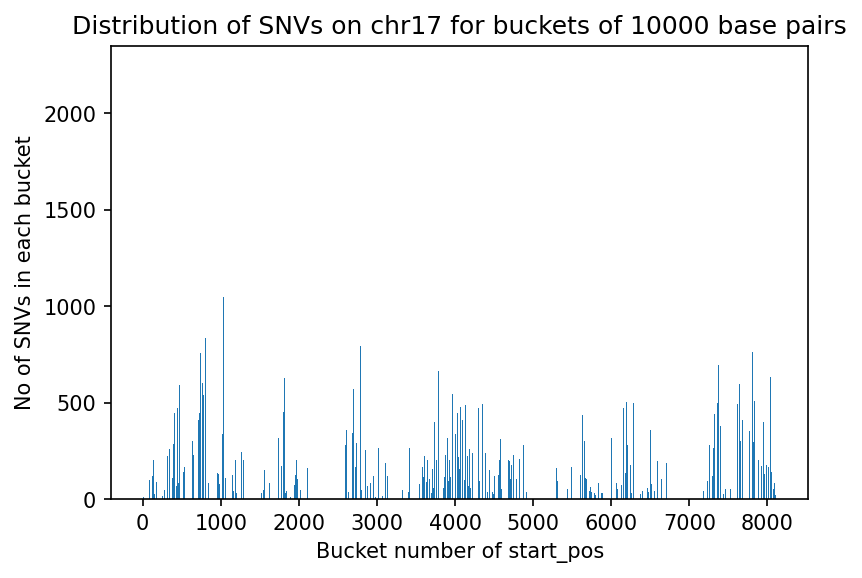

In [ ]:
import matplotlib.pyplot as plt

plt.figure(dpi=150)
plt.bar(snv_dist.start_pos_bucket, snv_dist.num_snv)
plt.xlabel("Bucket number of start_pos")
plt.ylabel("No of SNVs in each bucket")
plt.title("Distribution of SNVs on {} for buckets of {} base pairs".format(chromosome_chr, bucket_size))
plt.show()